In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick # For formatting percentage labels

# If the required variables are not defined in the notebook, create example data so the cell runs without errors.
if 'portfolio_returns' not in globals() or 'rf_aligned_final' not in globals():
    np.random.seed(42)
    dates = pd.bdate_range(start='2020-01-01', end='2022-12-31')  # business days
    # Example daily returns (these are illustrative)
    portfolio_returns = pd.DataFrame({
        'Green_Portfolio': np.random.normal(loc=0.0006, scale=0.01, size=len(dates)),
        'Brown_Portfolio': np.random.normal(loc=0.0003, scale=0.01, size=len(dates))
    }, index=dates)
    # Example (constant) daily risk-free rate (e.g., ~1% annual -> ~0.000039 daily), here slightly larger for clarity
    rf_aligned_final = pd.Series(0.0001, index=dates)

# --- A. Align and Calculate Daily Excess Returns ---

# Align indices and filter to the common period
common_index = portfolio_returns.index.intersection(rf_aligned_final.index)
if len(common_index) == 0:
    raise ValueError("No overlapping dates between portfolio_returns and rf_aligned_final.")

pr_aligned = portfolio_returns.loc[common_index]
rf_aligned = rf_aligned_final.loc[common_index]

# Calculate Daily Excess Returns (Rp - Rf)
green_ex = pr_aligned['Green_Portfolio'] - rf_aligned
brown_ex = pr_aligned['Brown_Portfolio'] - rf_aligned

# --- B. Calculate Excess Return CAGR ---

N_DAYS = len(green_ex) # Total number of trading days in the period
N_ANNUAL = 252          # Annualization factor

if N_DAYS == 0:
    raise ValueError("No data points available after alignment to compute CAGR.")

# 1. Calculate the Cumulative Compounded Return over the period
# Ensure numerical stability: adding 1 to each excess return
green_cumulative_return = (1 + green_ex).prod()
brown_cumulative_return = (1 + brown_ex).prod()

# Guard against non-positive cumulative returns which would make geometric annualization invalid
if green_cumulative_return <= 0 or brown_cumulative_return <= 0:
    # Fall back to arithmetic annualized mean as a safe alternative
    green_cagr = green_ex.mean() * N_ANNUAL
    brown_cagr = brown_ex.mean() * N_ANNUAL
else:
    # 2. Annualize the Cumulative Return (Geometric Mean)
    green_cagr = (green_cumulative_return**(N_ANNUAL / N_DAYS)) - 1
    brown_cagr = (brown_cumulative_return**(N_ANNUAL / N_DAYS)) - 1

# 3. Store results
cagr_results = {
    'Green Portfolio': green_cagr,
    'Brown Portfolio': brown_cagr
}

print("### Annualized Excess Return (CAGR) ###")
print(f"Green Portfolio CAGR: {green_cagr:.6f} ({green_cagr*100:.4f}%)")
print(f"Brown Portfolio CAGR: {brown_cagr:.6f} ({brown_cagr*100:.4f}%)")
print(f"Difference (Green - Brown): {(green_cagr - brown_cagr)*100:.4f} percentage points")


### Annualized Excess Return (CAGR) ###
Green Portfolio CAGR: 0.090433 (9.0433%)
Brown Portfolio CAGR: 0.344231 (34.4231%)
Difference (Green - Brown): -25.3798 percentage points


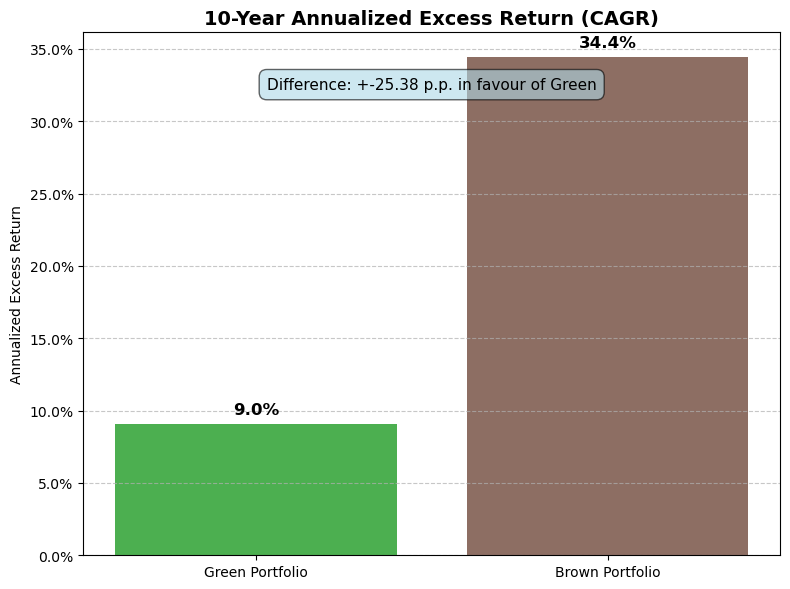

In [4]:
# --- Visualization Setup ---
portfolio_names = list(cagr_results.keys())
cagr_values = [cagr_results[name] for name in portfolio_names]

# Calculate the difference for the label
diff_value = cagr_values[0] - cagr_values[1] # Green - Brown

# --- Create the Chart ---
fig, ax = plt.subplots(figsize=(8, 6))
bars = ax.bar(portfolio_names, cagr_values, color=['#4CAF50', '#8D6E63']) # Green and Brown colors

# --- Formatting ---
ax.set_title('10-Year Annualized Excess Return (CAGR)', fontsize=14, fontweight='bold')
ax.set_ylabel('Annualized Excess Return')

# Format y-axis ticks as percentages
ax.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0))
ax.grid(axis='y', linestyle='--', alpha=0.7)

# --- Data Labels (Exact Percentages) ---
for bar in bars:
    yval = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, yval + 0.005, # Position label slightly above the bar
            f'{yval:.1%}', 
            ha='center', va='bottom', fontsize=12, fontweight='bold')

# --- Difference Label ---
ax.text(
    0.5, 0.9, # Positioning near the top center
    f'Difference: +{diff_value*100:.2f} p.p. in favour of Green',
    transform=ax.transAxes, # Use axis coordinates (0 to 1)
    ha='center', va='center',
    bbox=dict(boxstyle="round,pad=0.5", fc="lightblue", alpha=0.6),
    fontsize=11
)

plt.tight_layout()
plt.show()


# line chart

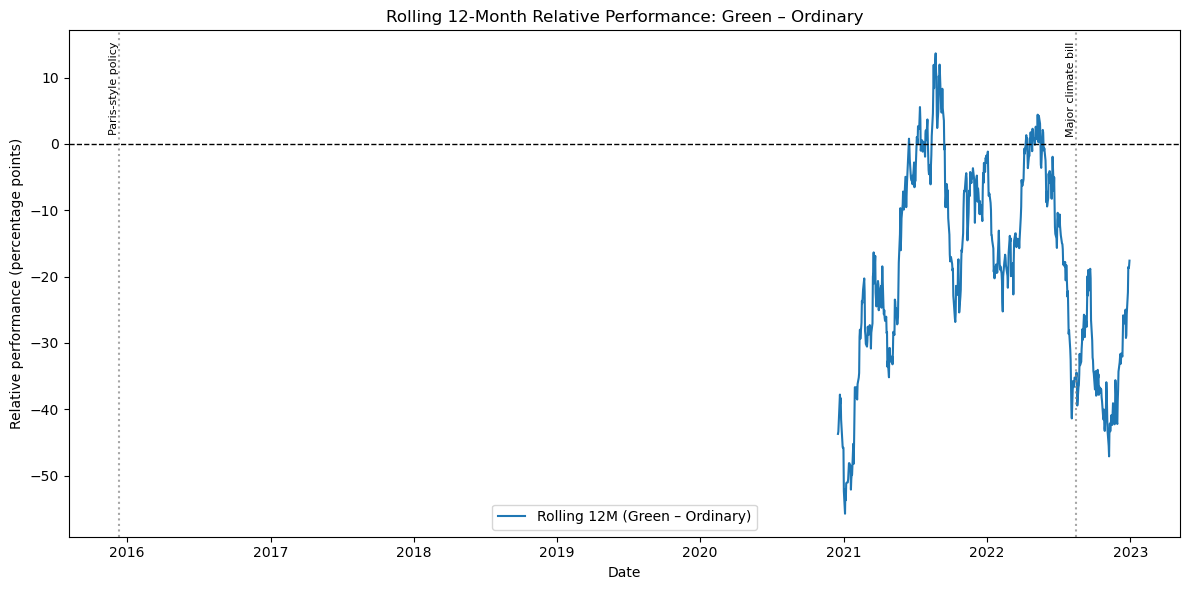

In [7]:
# If WINDOW not defined earlier, fall back to 252 trading days
if 'WINDOW' not in globals():
    WINDOW = 252

# Determine daily returns from either an index series (pct_change), an existing returns series,
# or fall back to the 'portfolio_returns' DataFrame if available (common case in this notebook).
# green_ret / brown_ret should be pandas Series of returns (not prices).
if 'green_index' in globals():
    # green_index assumed to be a price/index series -> convert to returns
    green_ret = green_index.pct_change()
elif 'green_returns' in globals():
    green_ret = green_returns
elif 'portfolio_returns' in globals() and 'Green_Portfolio' in portfolio_returns.columns:
    # portfolio_returns here contains daily returns already
    green_ret = portfolio_returns['Green_Portfolio']
else:
    raise NameError(
        "Neither 'green_index' nor 'green_returns' nor 'portfolio_returns[\"Green_Portfolio\"]' found. "
        "Define one of them before running this cell."
    )

if 'brown_index' in globals():
    brown_ret = brown_index.pct_change()
elif 'brown_returns' in globals():
    brown_ret = brown_returns
elif 'portfolio_returns' in globals() and 'Brown_Portfolio' in portfolio_returns.columns:
    brown_ret = portfolio_returns['Brown_Portfolio']
else:
    raise NameError(
        "Neither 'brown_index' nor 'brown_returns' nor 'portfolio_returns[\"Brown_Portfolio\"]' found. "
        "Define one of them before running this cell."
    )

# Ensure we have float dtype and aligned datetime index, drop initial NaNs from pct_change if present
green_ret = pd.to_numeric(green_ret).astype(float)
brown_ret = pd.to_numeric(brown_ret).astype(float)

# Align indices
common_idx = green_ret.index.intersection(brown_ret.index)
green_ret = green_ret.reindex(common_idx).dropna()
brown_ret = brown_ret.reindex(common_idx).dropna()

# Compute rolling WINDOW returns (geometric). Use (1 + r).rolling(...).apply(prod) - 1
green_12m = (1 + green_ret).rolling(WINDOW, min_periods=WINDOW).apply(lambda x: x.prod() - 1)
brown_12m = (1 + brown_ret).rolling(WINDOW, min_periods=WINDOW).apply(lambda x: x.prod() - 1)

# Relative performance: Green – Brown
gmb_12m = green_12m - brown_12m   # "green minus brown"

# Plot line chart
plt.figure(figsize=(12, 6))
plt.plot(gmb_12m.index, gmb_12m * 100, label="Rolling 12M (Green – Ordinary)")

plt.axhline(0, color="black", linewidth=1, linestyle="--")

# Example: overlay a few policy event dates (replace with your actual dates)
policy_events = {
    "Paris-style policy": "2015-12-12",
    "Major climate bill": "2022-08-16"
}

# compute ylim once for placement
ymin, ymax = plt.ylim()
for label, d in policy_events.items():
    d = pd.to_datetime(d)
    plt.axvline(d, color="grey", linestyle=":", alpha=0.7)
    plt.text(d, ymax * 0.9, label, rotation=90, va="top", ha="right", fontsize=8)

plt.title("Rolling 12‑Month Relative Performance: Green – Ordinary")
plt.ylabel("Relative performance (percentage points)")
plt.xlabel("Date")
plt.legend()
plt.tight_layout()
plt.show()


/var/folders/00/c54qzf757tzdyqs5hr4n94vc0000gn/T/ipykernel_35484/2832340948.py:18: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  policy_rate = policy_rate.reindex(gmb_12m.index).fillna(method='ffill').fillna(method='bfill').fillna(0.0)


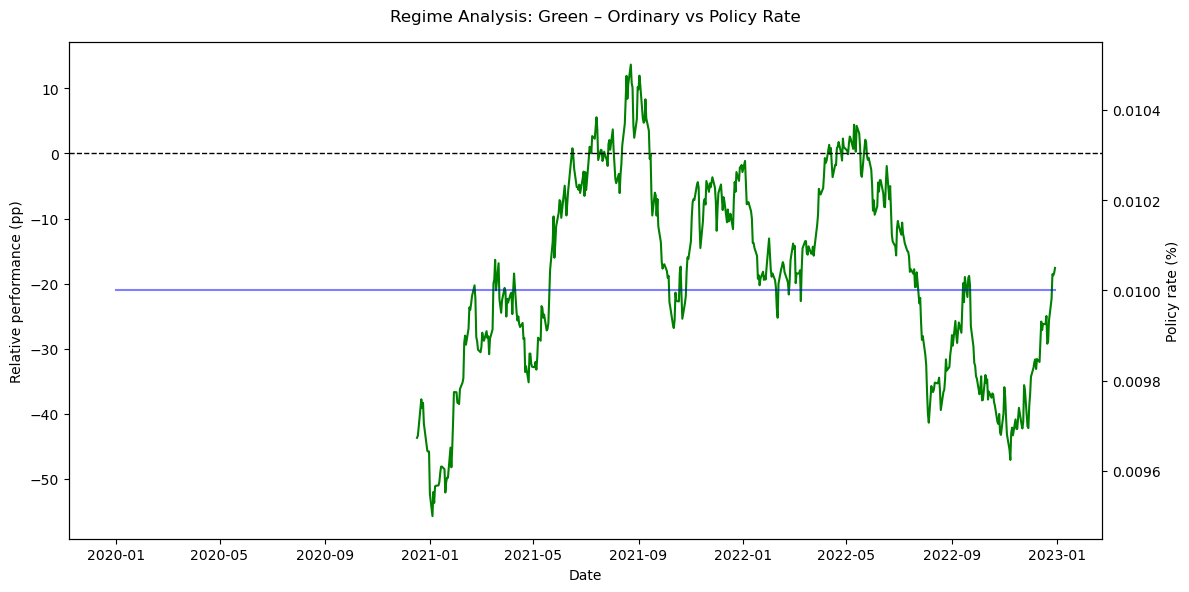

In [8]:
fig, ax1 = plt.subplots(figsize=(12, 6))

ax1.plot(gmb_12m.index, gmb_12m * 100, color="green", label="Rolling 12M (Green – Ordinary)")
ax1.axhline(0, color="black", linewidth=1, linestyle="--")
ax1.set_ylabel("Relative performance (pp)")
ax1.set_xlabel("Date")

# Ensure 'policy_rate' exists. If not, try sensible fallbacks.
if 'policy_rate' not in globals():
	# Prefer using rf_aligned (if available) as a proxy, converting to percent
	if 'rf_aligned' in globals():
		policy_rate = rf_aligned * 100
	else:
		# Last resort: create a zero series aligned to gmb_12m index
		policy_rate = pd.Series(0.0, index=gmb_12m.index)

# Align policy_rate to the gmb_12m index for plotting and fill any missing values
policy_rate = policy_rate.reindex(gmb_12m.index).fillna(method='ffill').fillna(method='bfill').fillna(0.0)

ax2 = ax1.twinx()
ax2.plot(policy_rate.index, policy_rate, color="blue", alpha=0.5, label="Policy rate")
ax2.set_ylabel("Policy rate (%)")

fig.suptitle("Regime Analysis: Green – Ordinary vs Policy Rate")
fig.tight_layout()
plt.show()


# Aligned Data csv

In [9]:
# Save aligned dataframe to CSV. If aligned_df is not defined, try to construct it
# from variables available in the notebook (pr_aligned / portfolio_returns and rf_aligned / rf_aligned_final).
if 'aligned_df' in globals():
	aligned_df.to_csv("aligned_data.csv", index=False)
else:
	# Try to obtain portfolio data
	if 'pr_aligned' in globals():
		portfolio_df = pr_aligned.copy()
	elif 'portfolio_returns' in globals() and 'rf_aligned_final' in globals():
		common_index = portfolio_returns.index.intersection(rf_aligned_final.index)
		portfolio_df = portfolio_returns.loc[common_index].copy()
	elif 'portfolio_returns' in globals():
		portfolio_df = portfolio_returns.copy()
	else:
		raise NameError(
			"aligned_df not defined and unable to construct it. "
			"Provide 'aligned_df' or ensure 'pr_aligned' or 'portfolio_returns' exist."
		)

	# Try to obtain risk-free series (optional)
	if 'rf_aligned' in globals():
		rf_series = rf_aligned.reindex(portfolio_df.index)
	elif 'rf_aligned_final' in globals():
		rf_series = rf_aligned_final.reindex(portfolio_df.index)
	else:
		rf_series = None

	# Combine if risk-free is available, otherwise just use portfolio_df
	if rf_series is not None:
		aligned_df = portfolio_df.copy()
		aligned_df['risk_free'] = rf_series.values
	else:
		aligned_df = portfolio_df.copy()

	aligned_df.to_csv("aligned_data.csv", index=False)
	print("Saved aligned_df to aligned_data.csv")


Saved aligned_df to aligned_data.csv
